In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, LSTM
from keras.preprocessing import sequence

from tqdm import tqdm
import os

In [2]:
!ls

lstm_asssignment.html  lstm_asssignment.ipynb  lstm_asssignment.pdf


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/gdrive/My Drive/Appliedai/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

In [ ]:
display['COUNT(*)'].sum()

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
final=final[:100000]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [ ]:
len(preprocessed_reviews)

### Performing required preprocessing for LSTM

In [ ]:
#get vocabulary
vocab=set()
for review in preprocessed_reviews:
    for each_word in review.split(' '):
        if each_word not in vocab:
            vocab.add(each_word)
vocab=list(vocab)
print("Number of words are",len(vocab))
all_words=len(vocab)

In [ ]:
from itertools import islice

vocab_count=dict.fromkeys(vocab,0)
for review in preprocessed_reviews:
    for word in review.split():
        vocab_count[word]+=1

counts=dict()
for key_value_pair in sorted(vocab_count,key=vocab_count.get,reverse=True):
    counts[key_value_pair]=vocab_count[key_value_pair]
    
with_index=list(islice(counts.items(),len(counts)))
with_index=[list(i) for i in with_index]

In [ ]:
index=0
for i in with_index:
    with_index[with_index.index(i)].append(with_index.index(i)+1)

In [ ]:
with_index[0]

In [ ]:
words=[i[0] for i in with_index]
sorted_index=[i[2] for i in with_index]
words_and_index=dict(zip(words,sorted_index))

In [ ]:
count=0
print('top 5 words and corresponding index:')
for i,j in words_and_index.items():
    if count>5:
        break
    print(i,j)
    count+=1

In [ ]:
new_preprocessed_reviews=[]
for sentance in preprocessed_reviews:
    each_review=[]
    for word in sentance.split(' '):
        each_review.append(words_and_index[word])
    new_preprocessed_reviews.append(each_review)
print(len(new_preprocessed_reviews))
print()
print(preprocessed_reviews[0])
print()
print('The above review in lstm format:')
print()
print(new_preprocessed_reviews[0])

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
def plt_accuracy(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation accuracy")
    ax.plot(x, ty, 'r', label="Train accuracy")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

### First LSTM (same as IMDB)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_preprocessed_reviews,final['Score'], test_size=0.33)

In [ ]:
from keras.preprocessing import sequence
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)

In [36]:
print(all_words+1)

59793


In [37]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(all_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 32)           1913376   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 1,966,677
Trainable params: 1,966,677
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
1047/1047 [==============================] - 50s 48ms/step - loss: 0.2413 - accuracy: 0.9060 - val_loss: 0.1926 - val_accuracy: 0.9264
Epoch 2/10
1047/1047 [==============================] - 49s 47ms/step - loss: 0.1515 - accuracy: 0.9421 - val_loss: 0.1920 - val_accuracy: 0.9266
Epoch 3/10
1047/1047 [==============================] - 49s 47ms/step - loss: 0.1187 - accuracy: 0.9571 - val_loss: 0.2114 - val_accuracy: 0.9241
Epoch 4/10
1047/1047 [==============================] - 49s 47ms/step - loss: 0.0920 - accuracy: 0.9674 - val_loss: 0.2229 - val_accuracy: 0.9190
Epoch 5/10
1047/1047 [==============================] - 49s 47ms/step - loss: 0.0692 - accuracy: 0.9768 - val_loss: 0.2573 - val_accuracy: 0.9113
Epoch 6/10
1047/1047 [==============================] - 49s 47ms/step - loss: 0.0538 - accuracy: 0.9823 - val_loss: 0.2847 - val_accuracy: 0.9170
Epoch 7/10
1047/1047 [==============================] - 49s 47ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.3077 -

Test score: 0.42868658900260925
Test accuracy: 0.910909116268158


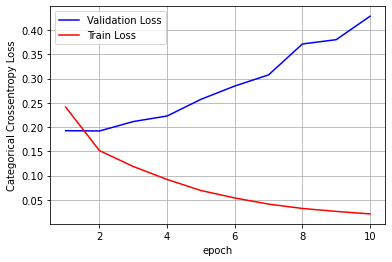

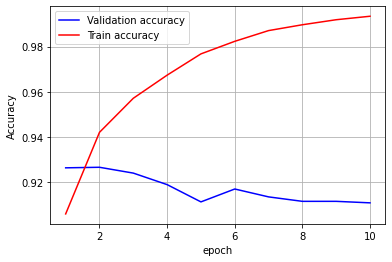

In [39]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plt_accuracy(x, vy, ty, ax)

### Second LSTM

In [60]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(all_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM(30))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 600, 32)           1913376   
_________________________________________________________________
lstm_15 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 30)                15720     
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 1,982,327
Trainable params: 1,982,327
Non-trainable params: 0
____________________________________________

In [61]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
1047/1047 [==============================] - 75s 72ms/step - loss: 0.2663 - accuracy: 0.9004 - val_loss: 0.1885 - val_accuracy: 0.9263
Epoch 2/10
1047/1047 [==============================] - 74s 70ms/step - loss: 0.1549 - accuracy: 0.9433 - val_loss: 0.1897 - val_accuracy: 0.9283
Epoch 3/10
1047/1047 [==============================] - 73s 70ms/step - loss: 0.1137 - accuracy: 0.9606 - val_loss: 0.2103 - val_accuracy: 0.9250
Epoch 4/10
1047/1047 [==============================] - 73s 70ms/step - loss: 0.0840 - accuracy: 0.9718 - val_loss: 0.2524 - val_accuracy: 0.9189
Epoch 5/10
1047/1047 [==============================] - 73s 70ms/step - loss: 0.0606 - accuracy: 0.9805 - val_loss: 0.3049 - val_accuracy: 0.9188
Epoch 6/10
1047/1047 [==============================] - 73s 70ms/step - loss: 0.0439 - accuracy: 0.9864 - val_loss: 0.2912 - val_accuracy: 0.9155
Epoch 7/10
1047/1047 [==============================] - 73s 70ms/step - loss: 0.0325 - accuracy: 0.9901 - val_loss: 0.3633 -

Test score: 0.4154008626937866
Test accuracy: 0.9140605926513672


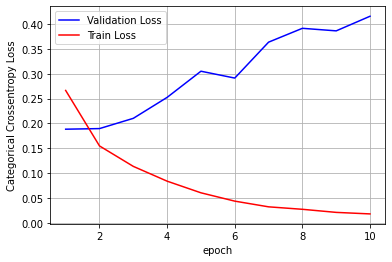

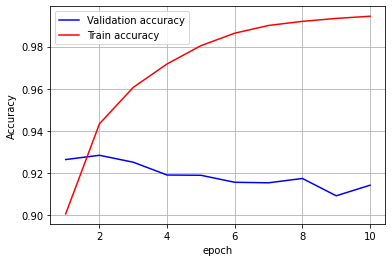

In [62]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
# list of epoch numbers
x = list(range(1,10+1))
vy = history.history['val_accuracy']
ty = history.history['accuracy']
plt_accuracy(x, vy, ty, ax)

## Observations:

In [67]:
from prettytable import PrettyTable
x = PrettyTable()
print('LSTM')
x.field_names = ["# Layers","unit size","Train accuracy","Test accuracy"]
x.add_row(["1","100","99.34%","91.04%"])
x.add_row(["2(with dropout)","[100,30]","99.45%","91.41%"])
print(x)

LSTM
+-----------------+-----------+----------------+---------------+
|     # Layers    | unit size | Train accuracy | Test accuracy |
+-----------------+-----------+----------------+---------------+
|        1        |    100    |     99.34%     |     91.04%    |
| 2(with dropout) |  [100,30] |     99.45%     |     91.41%    |
+-----------------+-----------+----------------+---------------+


1.I have tried BatchNormalization as the NN is not deep it is not adding much value,so ended up not using it.<br>
2.Adding more LSTM layers or units makes the model complex and is not increasing the performance too much.<br>
3.Dropout layer is slightly helping with overfitting.